In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
import itertools

In [ ]:
import pickle

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
def mse(true, pred):
  return ((1/len(true))*np.sum((true.subtract(pred,0))**2,0)).values[0]

def mape(true, pred):
  return ((1/len(true))*np.sum(abs(true.subtract(pred,0))/true,0)).values[0]

def mae(true, pred):
  return ((1/len(true))*np.sum(abs(true.subtract(pred,0)),0)).values[0]

def r2(true, pred):
  return 1-(np.sum(((pred-true.T)**2).T,0)/np.sum((true- true.mean())**2,0)).values[0]

In [ ]:
class Preprocessing:
  def __init__(self,train_link):
    self.__csv_df = pd.read_csv(train_link, parse_dates = True, index_col = 0)

    #self.__csv_df = self.__csv_df.sample(frac = 1)
    
    trainn = self.__csv_df.loc[:"2017-11-30 23:00:00"]
    test = self.__csv_df.loc["2018-01-01 00:00:00":]
    val = self.__csv_df.loc["2017-12-01 00:00:00":"2017-12-31 23:00:00"]

    self.__Y_train = pd.DataFrame(trainn.iloc[:, -1])
    self.__Y_val = pd.DataFrame(val.iloc[:, -1])
    self.__Y_test = pd.DataFrame(test.iloc[:, -1])

    self.__X_train = pd.DataFrame(trainn.iloc[:, :-1])
    self.__X_val = pd.DataFrame(val.iloc[:, :-1])
    self.__X_test = pd.DataFrame(test.iloc[:, :-1])
    
    #self.__X_train = pd.DataFrame(self.__csv_df.iloc[:int(len(self.__csv_df)*0.75), :-1].values)
    #self.__Y_train = pd.DataFrame(self.__csv_df.iloc[:int(len(self.__csv_df)*0.75), -1].values.reshape(-1,1))
    #self.__Y_val = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.75):int(len(self.__csv_df)*0.8), -1].values.reshape(-1,1))
    #self.__X_val = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.75):int(len(self.__csv_df)*0.8), :-1].values)
    #self.__X_test = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.8):, :-1].values)
    #self.__Y_test = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.8):, -1].values.reshape(-1,1))
    
    self.__eigenvectors = []
    
    self.__pve_list = []
    self.__pca = 0
    self.__X_train_processed = 0
    self.__number_of_components = 0
    self.__scaler = 0
    self.__abs_max_scaler = []
    self.__min_max_scaler = []
    self.__means = {}
    self.__vars  = {}

  def get_Y_val(self):
    return self.__Y_val

  def get_Y_test(self):
    return self.__Y_test

  def get_Y_train(self):
    return self.__Y_train

  def get_X_val(self):
    return self.__X_val

  def standard_scale(self, dffff):
    for column in dffff.columns:
          mean_one = np.mean(np.array(dffff[column]), 0)
          final_col_train = (dffff[column] - mean_one)
          stdd = np.std(final_col_train, ddof=0)
          final_col_train =  final_col_train/stdd

          dffff[column] = final_col_train

          self.__means[column] = mean_one
          self.__vars[column] = stdd
    return dffff

  def standard_scale_test(self,df):
    for column in df.columns:
          final_col_test = ( df[column].values - self.__means[column])/self.__vars[column] 
          df[column] = final_col_test
      
    return df


  def min_max_scaling(self,dataframe):
    self.__min_max_scaler = []
    for column in dataframe.columns:
      self.__min_max_scaler.append((dataframe[column].min(),dataframe[column].max()))
      dataframe[column] = (dataframe[column] - dataframe[column].min())/(dataframe[column].max() - dataframe[column].min())
    return dataframe

  def min_max_scaling_test(self,dataframe):
    for column in dataframe.columns:
      

      column_n = dataframe.columns.get_loc(column)
      print( self.__min_max_scaler[column_n][0],self.__min_max_scaler[column_n][1])
      print( dataframe[column])
      dataframe[column] = (dataframe[column] - self.__min_max_scaler[column_n][0])/(self.__min_max_scaler[column_n][1] - self.__min_max_scaler[column_n][0])
    return dataframe

  def abs_max_scaling(self,dataframe):
    for column in dataframe.columns:
      self.__abs_max_scaler.append(dataframe[column].abs().max())
      dataframe[column] = dataframe[column]  / dataframe[column].abs().max()
    return dataframe

  def preprocess_y_shape(self):
    self.__Y_test = self.min_max_scaling(self.__Y_test)
    self.__y_train = self.min_max_scaling(self.__Y_train)
    return self.__Y_test, self.__y_train

  def get_X_values(self):
    return self.__X_train, self.__X_test 
  
  def get_min_max_scaler(self):
    return self.__min_max_scaler

  def get_PCA_plot(self, threshold):
    df = self.__pve_list
    self.__number_of_components = [x+1 for x in range(len(df))]
    return self.__number_of_components, self.__pve_list

  def get_PVE(self):
    for i in range(len(self.__pve_list)):
      print(f"Number of components:{self.__number_of_components[i]} -> PVE:{self.__pve_list[i]}")
    
  def preprocess_train(self, X_train, threshold):
    X_train = self.min_max_scaling(self.__X_train)
    df_meaned = (X_train - np.mean(X_train, axis = 0))
    cov_matrix = np.cov(df_meaned, rowvar = False)
    values, vectors = np.linalg.eigh(cov_matrix)

    sorted_index = np.argsort(values)[::-1]
    sorted_eigenvalue = values[sorted_index]
    sorted_eigenvectors = vectors[:,sorted_index]

    pve = []
    for i in range(len(sorted_eigenvalue)):
        pve_percen = sum(sorted_eigenvalue[:i+1])*100 / np.sum(sorted_eigenvalue)
        pve.append(pve_percen)
    
    self.__pve_list = pve
    threshold_list = [pve.index(i) for i in pve if i >= threshold]
    threshold_out = threshold_list[0]

    sorted_index = sorted_index[:threshold_out+1]
    sorted_eigenvalue = sorted_eigenvalue[:threshold_out+1]
    sorted_eigenvectors = sorted_eigenvectors[:,:threshold_out+1]
    self.__eigenvectors = sorted_eigenvectors

    df_PCA = np.dot(sorted_eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_train = df_PCA
    return df_PCA
  
  def preprocess_test(self,X_test,X_train):
    X_test = self.min_max_scaling_test(self.__X_test)
    df_meaned = X_test - np.mean(X_train, axis = 0)
    df_PCA = np.dot(self.__eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_test = df_PCA
    return df_PCA
  def preprocess_val(self,X_val,X_train):
    X_val = self.min_max_scaling_test(self.__X_val)
    df_meaned = X_val - np.mean(X_train, axis = 0)
    df_PCA = np.dot(self.__eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_val = df_PCA
    return df_PCA
  def preprocess_train_ss(self, X_train, threshold):
    X_train = self.standard_scale(X_train)
    df_meaned = (X_train - np.mean(X_train, axis = 0))
    cov_matrix = np.cov(df_meaned, rowvar = False)
    values, vectors = np.linalg.eigh(cov_matrix)

    sorted_index = np.argsort(values)[::-1]
    sorted_eigenvalue = values[sorted_index]
    sorted_eigenvectors = vectors[:,sorted_index]

    pve = []
    for i in range(len(sorted_eigenvalue)):
        pve_percen = sum(sorted_eigenvalue[:i+1])*100 / np.sum(sorted_eigenvalue)
        pve.append(pve_percen)
    
    self.__pve_list = pve
    threshold_list = [pve.index(i) for i in pve if i >= threshold]
    threshold_out = threshold_list[0]

    sorted_index = sorted_index[:threshold_out+1]
    sorted_eigenvalue = sorted_eigenvalue[:threshold_out+1]
    sorted_eigenvectors = sorted_eigenvectors[:,:threshold_out+1]
    self.__eigenvectors = sorted_eigenvectors

    df_PCA = np.dot(sorted_eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_train = df_PCA
    return df_PCA
  
  def preprocess_test_ss(self,X_test,X_train):
    X_test = self.standard_scale_test(self.__X_test)
    df_meaned = X_test - np.mean(X_train, axis = 0)
    df_PCA = np.dot(self.__eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_test = df_PCA
    return df_PCA

In [ ]:
dataframe = Preprocessing("/content/drive/MyDrive/EEE 485 Project/Code/Features_label_raw.csv")

In [ ]:
X_train,X_test = dataframe.get_X_values()
X_train_o = X_train
X_train = dataframe.preprocess_train(X_train,95)
X_train

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,principal_componenet 11,principal_componenet 12,principal_componenet 13,principal_componenet 14,principal_componenet 15
0,1.302871,-0.495933,0.685117,0.518588,0.082945,-0.014194,0.588497,0.213073,-0.541380,-0.040026,-0.278103,-0.485133,0.059225,-0.073005,-0.085187
1,1.309744,-0.515187,0.700973,0.592722,-0.057264,-0.050078,0.635290,0.209962,-0.549906,-0.002292,-0.359998,-0.460813,0.045472,-0.037867,0.019006
2,1.307893,-0.515359,0.702773,0.603945,-0.182740,-0.082200,0.674213,0.203372,-0.554986,0.022060,-0.391507,-0.465843,0.019444,-0.050448,-0.005585
3,1.299136,-0.500933,0.701086,0.556296,-0.278612,-0.103937,0.700082,0.196794,-0.554964,0.031435,-0.403589,-0.476217,-0.009056,-0.058056,-0.028751
4,1.269049,-0.475439,0.696790,0.470626,-0.341663,-0.104242,0.700099,0.198294,-0.559738,0.060425,-0.472964,-0.428786,-0.006631,-0.007204,0.114347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25452,0.937617,0.467415,-0.918680,-0.585253,0.744822,0.235180,0.278800,0.011800,-0.473979,-0.126599,0.233614,-0.173844,0.009278,-0.056657,0.121034
25453,0.944814,0.460187,-0.930267,-0.590123,0.832551,0.244943,0.270717,0.009558,-0.469364,-0.190271,0.304878,-0.141336,0.030901,-0.093012,0.037517
25454,0.943603,0.436905,-0.912001,-0.534489,0.878640,0.256060,0.263723,0.019396,-0.483114,-0.206153,0.229601,-0.048282,0.142674,-0.019229,0.272851
25455,0.972135,0.398071,-0.884895,-0.394345,0.870430,0.236587,0.293666,0.016782,-0.494090,-0.236239,0.232798,-0.022408,0.184568,-0.022129,0.294897


In [ ]:
X_train.to_csv("/content/drive/MyDrive/EEE 485 Project/Code/PCA_mın_max.csv")

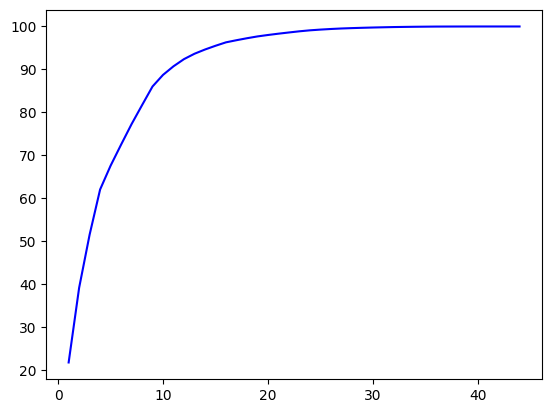

In [ ]:
(x_axis,y_axis) = dataframe.get_PCA_plot(100)

plt.plot(x_axis,y_axis,"b")

In [ ]:
X_test = dataframe.preprocess_test(X_test, X_train_o)
X_test

1359.7093125 1545.4700000000005
2018-01-01 00:00:00    1422.29
2018-01-01 01:00:00    1418.14
2018-01-01 02:00:00    1415.85
2018-01-01 03:00:00    1412.16
2018-01-01 04:00:00    1409.94
                        ...   
2018-12-31 19:00:00    1422.35
2018-12-31 20:00:00    1411.47
2018-12-31 21:00:00    1404.25
2018-12-31 22:00:00    1398.59
2018-12-31 23:00:00    1393.99
Name: temp, Length: 8756, dtype: float64
1352.75 1540.75
2018-01-01 00:00:00    1415.75
2018-01-01 01:00:00    1413.75
2018-01-01 02:00:00    1408.75
2018-01-01 03:00:00    1404.75
2018-01-01 04:00:00    1403.75
                        ...   
2018-12-31 19:00:00    1416.75
2018-12-31 20:00:00    1404.75
2018-12-31 21:00:00    1401.75
2018-12-31 22:00:00    1393.75
2018-12-31 23:00:00    1387.75
Name: temp_min, Length: 8756, dtype: float64
1359.7093125 1567.7400000000002
2018-01-01 00:00:00    1430.75
2018-01-01 01:00:00    1423.75
2018-01-01 02:00:00    1422.75
2018-01-01 03:00:00    1419.75
2018-01-01 04:00:00    1416.

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,principal_componenet 11,principal_componenet 12,principal_componenet 13,principal_componenet 14,principal_componenet 15
0,0.905375,-0.338786,-1.114445,0.590819,0.102919,0.106314,-0.663717,0.178964,-0.566710,0.095357,-0.611649,0.120034,0.321502,-0.088544,0.244745
1,0.914154,-0.354194,-1.104246,0.722568,0.009966,0.062078,-0.609061,0.175058,-0.565348,0.097795,-0.591383,-0.001199,0.348827,-0.110551,0.153674
2,0.938330,-0.368005,-1.099667,0.844191,-0.093578,0.006572,-0.530479,0.158628,-0.558699,0.054835,-0.501439,-0.097370,0.306235,-0.141045,0.018249
3,0.970441,-0.392735,-1.079100,0.972731,-0.217000,-0.047379,-0.447537,0.141804,-0.546708,0.024121,-0.456399,-0.146452,0.202433,-0.084582,0.069038
4,0.974019,-0.413587,-1.058642,1.045566,-0.352577,-0.084639,-0.399378,0.134414,-0.551283,0.053181,-0.522419,-0.110228,0.188150,-0.050642,0.144802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,0.921221,-0.002203,-1.260984,0.014115,0.154971,0.097536,-0.616267,0.042568,-0.435353,-0.092712,-0.020792,-0.450658,-0.178836,-0.033775,-0.096954
8752,0.940821,-0.020134,-1.273776,-0.017981,0.261385,0.111602,-0.625361,0.046298,-0.431225,-0.176513,0.019898,-0.431956,-0.083190,-0.016851,-0.022965
8753,0.972651,-0.059168,-1.257667,0.074940,0.306755,0.111405,-0.613911,0.050841,-0.431960,-0.219211,-0.005444,-0.380743,-0.028058,0.044973,0.161939
8754,0.996949,-0.099713,-1.232641,0.233913,0.281293,0.091970,-0.587537,0.053246,-0.437316,-0.215406,-0.033933,-0.382377,0.008075,0.055178,0.196454


In [ ]:
X_val  = dataframe.get_X_val()

X_val = dataframe.preprocess_val(X_val, X_train_o)
X_val

1359.7093125 1545.4700000000005
2017-12-01 00:00:00    1388.09
2017-12-01 01:00:00    1381.87
2017-12-01 02:00:00    1382.70
2017-12-01 03:00:00    1380.71
2017-12-01 04:00:00    1381.20
                        ...   
2017-12-31 19:00:00    1431.82
2017-12-31 20:00:00    1430.89
2017-12-31 21:00:00    1429.73
2017-12-31 22:00:00    1428.11
2017-12-31 23:00:00    1424.73
Name: temp, Length: 744, dtype: float64
1352.75 1540.75
2017-12-01 00:00:00    1382.75
2017-12-01 01:00:00    1376.75
2017-12-01 02:00:00    1377.75
2017-12-01 03:00:00    1376.75
2017-12-01 04:00:00    1375.75
                        ...   
2017-12-31 19:00:00    1427.75
2017-12-31 20:00:00    1423.75
2017-12-31 21:00:00    1423.75
2017-12-31 22:00:00    1422.75
2017-12-31 23:00:00    1417.75
Name: temp_min, Length: 744, dtype: float64
1359.7093125 1567.7400000000002
2017-12-01 00:00:00    1394.75
2017-12-01 01:00:00    1387.75
2017-12-01 02:00:00    1388.75
2017-12-01 03:00:00    1385.75
2017-12-01 04:00:00    1387.75

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,principal_componenet 11,principal_componenet 12,principal_componenet 13,principal_componenet 14,principal_componenet 15
0,1.070638,0.183927,-0.825489,0.028968,0.475535,0.629698,0.154421,0.157653,-0.450796,-0.305279,0.204171,-0.163422,0.034800,-0.014815,0.295173
1,1.119856,0.117123,-0.790256,0.308516,0.342365,0.578085,0.221490,0.145897,-0.463615,-0.264684,0.188846,-0.155911,-0.032318,-0.070943,0.176008
2,1.119002,0.095315,-0.758711,0.483830,0.195309,0.532402,0.271660,0.141914,-0.473217,-0.195563,0.138656,-0.204487,-0.048254,-0.099394,0.072925
3,1.148112,0.060108,-0.737591,0.651000,0.055405,0.480112,0.342559,0.128403,-0.478858,-0.189538,0.132006,-0.200317,-0.087343,-0.118705,0.035527
4,1.146542,0.052965,-0.728494,0.708711,-0.075228,0.438489,0.395187,0.118206,-0.485190,-0.177423,0.110286,-0.200631,-0.087506,-0.130779,0.003581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,0.959433,-0.090147,-0.745513,0.071052,0.125351,0.153215,-0.720598,0.039440,-0.565609,0.116421,-0.428338,0.460719,-0.062047,-0.260154,0.005866
740,0.952156,-0.076844,-0.763216,0.037213,0.222696,0.165199,-0.730154,0.050658,-0.562552,0.052379,-0.388203,0.387793,0.071152,-0.226239,0.083525
741,0.948570,-0.080406,-0.762802,0.116893,0.262244,0.160754,-0.726005,0.069990,-0.571703,0.038885,-0.419611,0.236854,0.296483,-0.208559,0.185962
742,0.962394,-0.109785,-0.746138,0.268403,0.237904,0.139540,-0.697939,0.069344,-0.578351,0.037660,-0.413125,0.226684,0.324283,-0.226548,0.147106


In [ ]:
X_test.to_csv("/content/drive/MyDrive/EEE 485 Project/Code/PCA_minmax_test.csv")

In [ ]:
Y_train = dataframe.get_Y_train()
Y_test = dataframe.get_Y_test()
Y_train = dataframe.min_max_scaling(Y_train)
Y_test = dataframe.min_max_scaling_test(Y_test)
dataframe.get_min_max_scaler()

[(0.0, 41015.0)]

In [ ]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, SDR=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.SDR = SDR
        self.value = value

In [ ]:
class DecisionTree():
  def __init__(self,max_depth=2):
    self.__root = None
    self.__max_depth = max_depth
    self.__min_samples_split = 3

  def SDR(self, parent, l_child, r_child):
    weight_l = len(l_child) / len(parent)
    weight_r = len(r_child) / len(parent)
    gain = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
    return gain

  def split(self, dataset, feature_index, threshold): 
    dataset_right = dataset[dataset[:,feature_index]>threshold]
    dataset_left = dataset[dataset[:,feature_index]<=threshold]
    return dataset_left, dataset_right

  def best_split(self, dataset, num_features):
    best_split = {}
    max_sdr = -float("inf")
    for feature_index in range(num_features):
      feature_values = dataset[:,feature_index]
      possible_thresholds = np.unique(feature_values)
      for threshold in possible_thresholds:
        dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
        if len(dataset_left)>0 and len(dataset_right)>0:
          y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
          curr_sdr = self.SDR(y, left_y, right_y)
          if curr_sdr>max_sdr:
            best_split["feature_index"] = feature_index
            best_split["threshold"] = threshold
            best_split["dataset_left"] = dataset_left
            best_split["dataset_right"] = dataset_right
            best_split["SDR"] = curr_sdr
            max_sdr = curr_sdr
    return best_split

  def tree_itself(self, dataset, curr_depth=0):
    X, Y = dataset[:,:-1], dataset[:,-1]
    num_samples, num_features = np.shape(X)
    best_split = {}
    if num_samples>=self.__min_samples_split and curr_depth<=self.__max_depth:
        best_split = self.best_split(dataset, num_features)
        if best_split["SDR"]>0:
            left_subtree = self.tree_itself(best_split["dataset_left"], curr_depth+1)
            right_subtree = self.tree_itself(best_split["dataset_right"], curr_depth+1)
            return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree, best_split["SDR"])
    
    leaf_value = np.mean(Y)
    return Node(value=leaf_value)

  def make_prediction(self, x, tree):     
    if tree.value!=None: 
      return tree.value
    feature_val = x[tree.feature_index]
   

    if feature_val<=tree.threshold:
        return self.make_prediction(x, tree.left)
    else:
        return self.make_prediction(x, tree.right)
    
  def predict(self, X):
    preditions = [self.make_prediction(x, self.__root) for x in X]
    return preditions

  def fit(self, X, Y):
    dataset = np.concatenate((X, Y), axis = 1)
    self.__root = self.tree_itself(dataset)

  def get_root(self):
    return self.__root

# Regression Tree Grid Search Demo

In [ ]:
parameters = {"depth": [10,11,12],
}
param_values = [v for v in parameters.values()] 
error_of_choice= []
whole_turns = []
threshold = 100
for depth in itertools.product(*param_values):
  t = time.time()
  depth = int(depth[0])
  regressor = DecisionTree(max_depth=depth)
  regressor.fit(X_train.iloc[:,:5],Y_train)
  print("Duration: " + str(time.time()-t) + " seconds")
  y_pred = regressor.predict(X_test.iloc[:,:5].to_numpy())
  MSE = mse(Y_test,y_pred)
  error_of_choice.append(MSE)
  whole_turns.append(depth)
  print('Maximum Depth: %.3f, MSE:%.3f' % (depth,MSE))
  if MSE < threshold:
    threshold = MSE
    model = regressor
    E = depth

with open('/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Regression_Tree_first_5.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_test, Y_test, model], f, protocol=pickle.HIGHEST_PROTOCOL)   
print("Best Maximum Depth: " + str(E))

Duration: 553.2609302997589 seconds
Maximum Depth: 10.000, MSE:0.003
Duration: 564.563366651535 seconds
Maximum Depth: 11.000, MSE:0.003
Duration: 573.0171072483063 seconds
Maximum Depth: 12.000, MSE:0.003
Best Maximum Depth: 11


In [ ]:
MSE,depth

(0.0029610063775766535, 12)

In [ ]:
filename = "/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Regression_Tree_first_5.pickle"
pick = pickle.load(open(filename, 'rb'))
X_train_p, Y_train_p, X_test_p, Y_test_p, features_p = pick
y_pred_p = regressor.predict(X_test_p.iloc[:,:5].to_numpy())

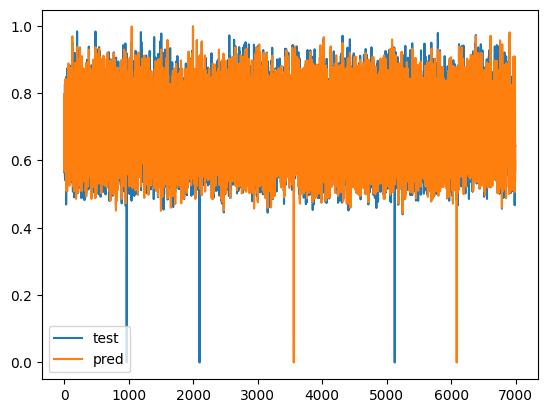

In [ ]:
plt.plot(Y_test_p.index, Y_test_p)
plt.plot(Y_test_p.index, y_pred_p)

plt.legend(["test","pred"])

In [ ]:
print("MSE: " + str(mse(Y_test_p,y_pred_p)))
print("MAPE: " + str(mape(Y_test_p,y_pred_p)))
print("MAE: " + str(mae(Y_test_p,y_pred_p)))
print("R2 Score: " + str(r2(Y_test_p,y_pred_p)))

MSE: 0.0029610063775766535
MAPE: inf
MAE: 0.0372550537672312
R2 Score: 0.7660621579589018


# Regression Tree Grid Search

In [ ]:
parameters = {"depth": [10,11,12],
}
param_values = [v for v in parameters.values()] 
error_of_choice= []
whole_turns = []
threshold = 100
for depth in itertools.product(*param_values):
  t = time.time()
  depth = int(depth[0])
  regressor = DecisionTree(min_samples_split=3, max_depth=depth)
  regressor.fit(X_train,Y_train)
  print("Duration: " + str(time.time()-t) + " seconds")
  y_pred = regressor.predict(X_test.to_numpy())
  MSE = mse(Y_test,y_pred)
  error_of_choice.append(MSE)
  whole_turns.append(depth)
  print('Maximum Depth: %.3f, MSE:%.15f' % (depth,MSE))
  if MSE < threshold:
    threshold = MSE
    model = regressor
    E = depth

with open('/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Regression_Tree.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_test, Y_test, model], f, protocol=pickle.HIGHEST_PROTOCOL)   
print("Best Maximum Depth: " + str(E))

Duration: 2123.660002231598 seconds
Maximum Depth: 10.000, MSE:0.001927245518503
Duration: 2141.4180240631104 seconds
Maximum Depth: 11.000, MSE:0.001869383684337
Duration: 2152.472796201706 seconds
Maximum Depth: 12.000, MSE:0.001981181865609
Best Maximum Depth: 11


In [ ]:
MSE,depth,E

(0.0019811818656089515, 12, 11)

In [ ]:
filename = "/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Regression_Tree.pickle"
pick = pickle.load(open(filename, 'rb'))
X_train_p, Y_train_p, X_test_p, Y_test_p, features_p = pick
y_pred_p = regressor.predict(X_test_p.to_numpy())
y_pred_p_train = regressor.predict(X_train_p.to_numpy())

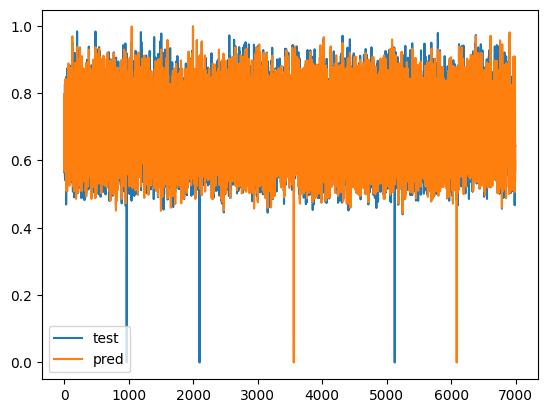

In [ ]:
plt.plot(Y_test_p.index, Y_test_p)
plt.plot(Y_test_p.index, y_pred_p)

plt.legend(["test","pred"])

In [ ]:
print("Train MSE: " + str(mse(Y_train,y_pred_p_train)))
print("Train MAE: " + str(mae(Y_train,y_pred_p_train)))
print("Train R2 Score: " + str(r2(Y_train,y_pred_p_train)))

print("Test MSE: " + str(mse(Y_test,y_pred_p)))
print("Test MAE: " + str(mae(Y_test,y_pred_p)))
print("Test R2 Score: " + str(r2(Y_test,y_pred_p)))

Train MSE: 0.0004388501705548615
Train MAE: 0.014194871324742557
Train R2 Score: 0.965529330283976
Test MSE: 0.0019811818656089515
Test MAE: 0.028438730170327754
Test R2 Score: 0.8434743626892046


# PCA Minmax Scale

In [ ]:
t = time.time()
regressor = DecisionTree(max_depth=11)
regressor.fit(X_train,Y_train)
print("Duration: " + str(time.time()-t) + " seconds")
y_pred = regressor.predict(X_test.to_numpy())
MSE = mse(Y_test,y_pred)

with open('/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Regression_Tree_sebcgv.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_test, Y_test, regressor], f, protocol=pickle.HIGHEST_PROTOCOL)   

Duration: 1803.2353098392487 seconds


In [ ]:
filename = "/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Regression_Tree_sebcgv.pickle"
pick = pickle.load(open(filename, 'rb'))
X_train_p, Y_train_p, X_test_p, Y_test_p, features_p = pick
y_pred_p = features_p.predict(X_test_p.to_numpy())
y_pred_p_train = features_p.predict(X_train_p.to_numpy())

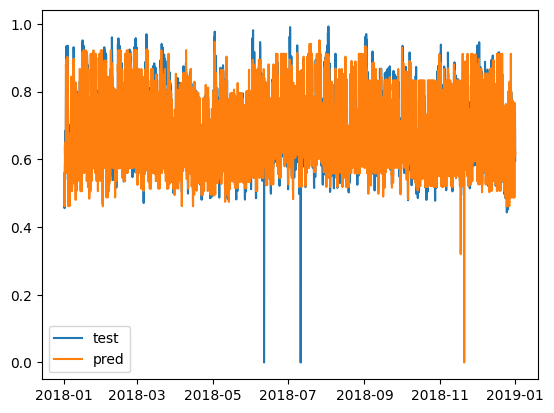

In [ ]:
plt.plot(Y_test_p.index, Y_test_p)
plt.plot(Y_test_p.index, y_pred_p)

plt.legend(["test","pred"])

In [ ]:
len(y_pred_p_train)

25457

In [ ]:
print("Train MSE: " + str(mse(Y_train_p,y_pred_p_train)))
print("Train MAE: " + str(mae(Y_train_p,y_pred_p_train)))
print("Train R2 Score: " + str(r2(Y_train_p,y_pred_p_train)))

print("Test MSE: " + str(mse(Y_test,y_pred_p)))
print("Test MAE: " + str(mae(Y_test,y_pred_p)))
print("Test R2 Score: " + str(r2(Y_test,y_pred_p)))

Train MSE: 0.000545053072570515
Train MAE: 0.016244373408327305
Train R2 Score: 0.9566056002733588
Test MSE: 0.002281208901936088
Test MAE: 0.03473035788955841
Test R2 Score: 0.8222694046355786


# PCA SS

In [ ]:
dataframe = Preprocessing("/content/drive/MyDrive/EEE 485 Project/Code/Features_label_raw.csv")

In [ ]:
X_train,X_test = dataframe.get_X_values()
X_train_o = X_train
X_train = dataframe.preprocess_train_ss(X_train,95)
X_train

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,...,principal_componenet 13,principal_componenet 14,principal_componenet 15,principal_componenet 16,principal_componenet 17,principal_componenet 18,principal_componenet 19,principal_componenet 20,principal_componenet 21,principal_componenet 22
0,6.429736,-1.568045,5.783088,-2.408599,-12.574068,3.750964,1.611203,0.817502,0.425884,1.921974,...,0.420414,0.079305,-0.454323,-0.785861,-1.096982,-0.477925,-0.888825,-1.194259,0.405068,-1.773461
1,6.939078,-1.160785,6.702152,-2.571491,-15.037919,3.771560,1.853552,1.527765,0.430415,1.939445,...,0.625880,-0.042199,-0.877306,-0.697418,-0.903353,-0.184016,-0.448208,-1.142924,0.065765,-1.835596
2,7.116403,-0.953623,7.697477,-2.746923,-17.650389,3.844435,1.846964,2.343337,0.468319,2.404516,...,0.691741,-0.076049,-0.905049,-0.586359,-0.893269,-0.102026,-0.447217,-1.285088,-0.189701,-2.044525
3,7.060779,-0.962577,8.544153,-3.023112,-19.924346,4.093348,1.894022,3.020337,0.526134,2.740380,...,0.680524,-0.051028,-0.941340,-0.534145,-0.921539,0.006801,-0.510427,-1.316784,-0.432736,-2.198870
4,6.910436,-0.913361,9.208552,-3.206897,-21.684338,4.559531,2.428760,3.216929,0.620112,2.509873,...,0.700087,-0.196572,-1.356129,-0.515117,-0.496268,0.183445,0.216240,-0.678796,-0.792952,-1.922919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25452,-2.158423,-6.244871,1.880470,1.722098,1.477578,0.998504,0.629393,-0.353714,-1.830938,-0.539511,...,0.584124,-1.289334,-2.533791,0.316913,-0.067840,0.171269,0.250267,-0.754737,-0.377074,-0.651462
25453,-2.465450,-6.549312,1.571907,1.804572,1.357597,0.436953,0.468479,0.155424,-2.079697,0.331671,...,0.564269,-1.064705,-1.842735,0.541496,0.073785,0.541368,0.068923,-0.759401,0.113102,-1.392929
25454,-2.412802,-6.208973,0.987225,1.706072,0.823955,-0.673681,0.746861,0.174123,-2.791919,0.226649,...,0.924656,-1.146645,-2.168614,1.038727,0.676158,0.895039,0.275164,-0.202838,-0.021270,-1.300651
25455,-1.681050,-5.919386,0.983268,1.600819,0.962674,-0.230977,1.319480,-0.304030,-2.330228,-0.053207,...,0.805799,-1.198171,-1.973643,0.873268,0.661133,0.847160,0.130193,0.040504,0.140040,-1.146505


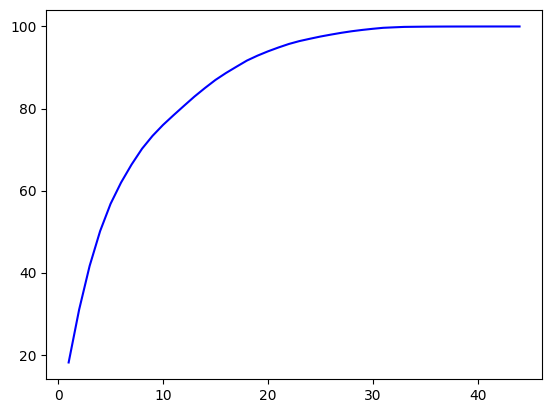

In [ ]:
(x_axis,y_axis) = dataframe.get_PCA_plot(100)
plt.plot(x_axis,y_axis,"b")

In [ ]:
X_test = dataframe.preprocess_test_ss(X_test, X_train_o)
X_test

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,...,principal_componenet 13,principal_componenet 14,principal_componenet 15,principal_componenet 16,principal_componenet 17,principal_componenet 18,principal_componenet 19,principal_componenet 20,principal_componenet 21,principal_componenet 22
0,3.830432,0.426559,-0.379901,2.318570,-1.056518,-3.293923,2.166802,-3.962123,-0.535213,-1.261593,...,0.189129,0.061554,-0.839360,0.315695,0.685025,0.646309,0.301365,-0.620115,0.285864,-0.058030
1,4.203008,0.950035,0.088121,2.450281,-1.108014,-3.379440,1.178351,-3.939765,-0.530404,-0.608255,...,0.202884,0.126317,-0.429048,0.501323,0.791415,0.370658,0.170064,-0.700438,0.646446,-0.352886
2,4.557401,1.167206,0.512624,2.655092,-0.974580,-3.276193,0.555606,-3.677900,-0.197147,-0.164624,...,0.158909,0.293834,0.014488,0.394601,0.856451,0.234885,-0.555575,-1.164833,0.967753,-0.748176
3,5.228889,1.356205,0.912196,2.701904,-0.650345,-2.765861,0.512086,-3.321351,0.365996,-0.415631,...,0.167444,0.465709,-0.215299,-0.031434,1.092409,0.376390,-0.437170,-1.101827,1.273574,-0.724770
4,5.609498,1.761897,0.820983,2.663365,-0.789575,-3.261082,0.418173,-3.041793,0.443781,-0.821311,...,0.382385,0.392353,-0.600308,-0.044754,1.074100,0.743074,-0.389198,-1.174647,1.056623,-0.734499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,0.887606,-3.088208,2.222899,2.832420,1.409780,0.328687,-0.625220,-2.165976,-0.372835,-0.610493,...,-0.673049,0.774427,-2.078034,-0.791055,-0.752510,0.505540,0.825328,-0.646362,0.592891,0.216273
8752,0.597172,-3.541361,1.833694,2.862351,1.080874,-0.211537,-0.828566,-2.106644,-0.943366,-0.207435,...,-0.504606,0.802333,-1.946820,-0.238587,-0.315911,0.578900,0.715755,-0.486274,0.718060,0.121037
8753,0.839923,-3.472411,1.521189,2.835235,0.762314,-1.047759,-0.814098,-1.718713,-1.736716,-0.120245,...,-0.117807,0.846599,-2.304912,0.323805,0.123954,0.857515,0.850798,-0.338885,0.593604,0.060926
8754,1.577163,-3.130552,1.600237,2.871062,0.920474,-0.655412,-0.339483,-2.108475,-1.341980,-0.687117,...,-0.192517,0.735396,-2.296095,0.021321,0.057038,0.952712,0.659263,-0.306727,0.713089,-0.027101


In [ ]:
Y_train = dataframe.get_Y_train()
Y_test = dataframe.get_Y_test()
Y_train = dataframe.standard_scale(Y_train)
Y_test = dataframe.standard_scale_test(Y_test)

In [ ]:
t = time.time()
regressor = DecisionTree(max_depth=11)
regressor.fit(X_train,Y_train)
print("Duration: " + str(time.time()-t) + " seconds")
y_pred = regressor.predict(X_test.to_numpy())
MSE = mse(Y_test,y_pred)

with open('/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Regression_Tree_ss.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_test, Y_test, regressor], f, protocol=pickle.HIGHEST_PROTOCOL)   

Duration: 2892.1055109500885 seconds


In [ ]:
filename = "/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Regression_Tree_ss.pickle"
pick = pickle.load(open(filename, 'rb'))
X_train_p, Y_train_p, X_test_p, Y_test_p, features_p = pick
y_pred_p = features_p.predict(X_test_p.to_numpy())
y_pred_p_train = features_p.predict(X_train_p.to_numpy())

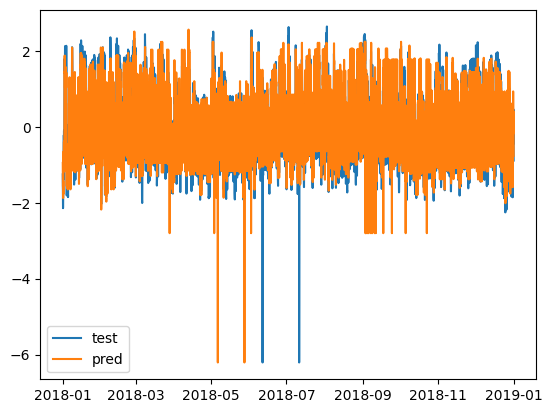

In [ ]:
plt.plot(Y_test_p.index, Y_test_p)
plt.plot(Y_test_p.index, y_pred_p)

plt.legend(["test","pred"])

In [ ]:
print("Train MSE: " + str(mse(Y_train_p,y_pred_p_train)))
print("Train MAE: " + str(mae(Y_train_p,y_pred_p_train)))
print("Train R2 Score: " + str(r2(Y_train_p,y_pred_p_train)))

print("Test MSE: " + str(mse(Y_test_p,y_pred_p)))
print("Test MAE: " + str(mae(Y_test_p,y_pred_p)))
print("Test R2 Score: " + str(r2(Y_test_p,y_pred_p)))

Train MSE: 0.052519478329150174
Train MAE: 0.15982675692208195
Train R2 Score: 0.9474805216708498
Test MSE: 0.24201089700771072
Test MAE: 0.3364093913788618
Test R2 Score: 0.763169753815046


# MinMax Scale

In [ ]:
dataframe = Preprocessing("/content/drive/MyDrive/EEE 485 Project/Code/Features_label_raw.csv")

In [ ]:
X_train,X_test = dataframe.get_X_values()
X_train = X_train.reset_index().drop("index",axis=1)
X_test = X_test.reset_index().drop("index",axis=1)
X_val = dataframe.get_X_val().reset_index().drop("index",axis=1)
X_train = dataframe.min_max_scaling(X_train)
X_val = dataframe.min_max_scaling_test(X_val)
X_test = dataframe.min_max_scaling_test(X_test)

In [ ]:
Y_train = dataframe.get_Y_train().reset_index().drop("index",axis=1)
Y_test = dataframe.get_Y_test().reset_index().drop("index",axis=1)
Y_val = dataframe.get_Y_val().reset_index().drop("index",axis=1)
Y_train = dataframe.min_max_scaling(Y_train)
Y_val = dataframe.min_max_scaling_test(Y_val)
Y_test = dataframe.min_max_scaling_test(Y_test)

In [ ]:
t = time.time()
regressor = DecisionTree(max_depth=11)
regressor.fit(X_train,Y_train)
print("Duration: " + str(time.time()-t) + " seconds")
y_pred = regressor.predict(X_test.to_numpy())
MSE = mse(Y_test,y_pred)

with open('/content/drive/MyDrive/EEE 485 Project/Code/code_final/Regression_Tree_ss.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_test, Y_test, regressor], f, protocol=pickle.HIGHEST_PROTOCOL)   

Duration: 2332.592651605606 seconds


In [ ]:
filename = "/content/drive/MyDrive/EEE 485 Project/Code/code_final/Regression_Tree_ss.pickle"
pick = pickle.load(open(filename, 'rb'))
X_train_p, Y_train_p, X_test_p, Y_test_p, features_p = pick
y_pred_p = features_p.predict(X_test_p.to_numpy())
y_pred_p_train = features_p.predict(X_train_p.to_numpy())

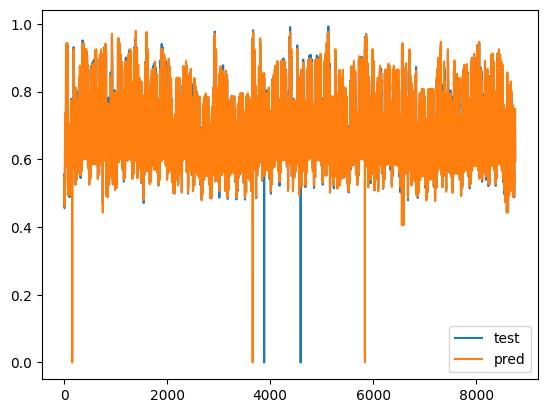

In [ ]:
plt.plot(Y_test_p.index, Y_test_p)
plt.plot(Y_test_p.index, y_pred)

plt.legend(["test","pred"])

In [ ]:
print("Train MSE: " + str(mse(Y_train_p,y_pred_p_train)))
print("Train MAE: " + str(mae(Y_train_p,y_pred_p_train)))
print("Train R2 Score: " + str(r2(Y_train_p,y_pred_p_train)))

print("Test MSE: " + str(mse(Y_test_p,y_pred_p)))
print("Test MAE: " + str(mae(Y_test_p,y_pred_p)))
print("Test R2 Score: " + str(r2(Y_test_p,y_pred_p)))

Train MSE: 0.00011258594466980215
Train MAE: 0.006287922705643861
Train R2 Score: 0.9910364701485637
Test MSE: 0.0009584974922927638
Test MAE: 0.01214716806289881
Test R2 Score: 0.9253227839783037


# SS

In [ ]:
dataframe = Preprocessing("/content/drive/MyDrive/EEE 485 Project/Code/Features_label_raw.csv")

In [ ]:
X_train,X_test = dataframe.get_X_values()
X_train = X_train.reset_index().drop("index",axis=1)
X_test = X_test.reset_index().drop("index",axis=1)
X_val = dataframe.get_X_val().reset_index().drop("index",axis=1)
X_train = dataframe.standard_scale(X_train)
X_val = dataframe.standard_scale_test(X_val)
X_test = dataframe.standard_scale_test(X_test)

In [ ]:
Y_train = dataframe.get_Y_train().reset_index().drop("index",axis=1)
Y_test = dataframe.get_Y_test().reset_index().drop("index",axis=1)
Y_val = dataframe.get_Y_val().reset_index().drop("index",axis=1)
Y_train = dataframe.standard_scale(Y_train)
Y_val = dataframe.standard_scale_test(Y_val)
Y_test = dataframe.standard_scale_test(Y_test)

In [ ]:
t = time.time()
regressor = DecisionTree(max_depth=11)
regressor.fit(X_train,Y_train)
print("Duration: " + str(time.time()-t) + " seconds")
y_pred = regressor.predict(X_test.to_numpy())
MSE = mse(Y_test,y_pred)

with open('/content/drive/MyDrive/EEE 485 Project/Code/code_final/Regression_Tree_ss_real.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_test, Y_test, regressor], f, protocol=pickle.HIGHEST_PROTOCOL)   

Duration: 3157.1156375408173 seconds


In [ ]:
filename = "/content/drive/MyDrive/EEE 485 Project/Code/code_final/Regression_Tree_ss_real.pickle"
pick = pickle.load(open(filename, 'rb'))
X_train_p, Y_train_p, X_test_p, Y_test_p, features_p = pick
y_pred_p = features_p.predict(X_test_p.to_numpy())
y_pred_p_train = features_p.predict(X_train_p.to_numpy())

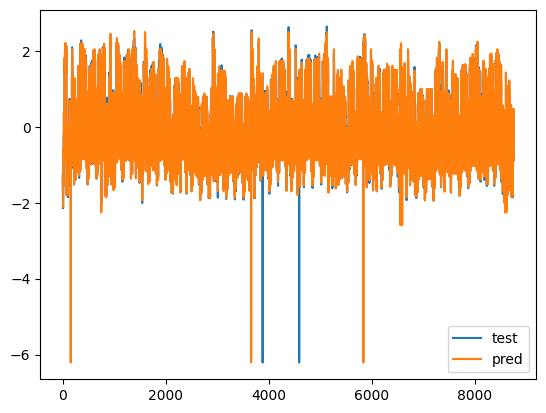

In [ ]:
plt.plot(Y_test_p.index, Y_test_p)
plt.plot(Y_test_p.index, y_pred)

plt.legend(["test","pred"])

In [ ]:
print("Train MSE: " + str(mse(Y_train,y_pred_p_train)))
print("Train MAE: " + str(mae(Y_train,y_pred_p_train)))
print("Train R2 Score: " + str(r2(Y_train,y_pred_p_train)))

print("Test MSE: " + str(mse(Y_test,y_pred_p)))
print("Test MAE: " + str(mae(Y_test,y_pred_p)))
print("Test R2 Score: " + str(r2(Y_test_p,y_pred_p)))

Train MSE: 0.008975860489878425
Train MAE: 0.05615241968391498
Train R2 Score: 0.9910241395101216
Test MSE: 0.07624165140517487
Test MAE: 0.10824867853683753
Test R2 Score: 0.9253904295422709


# Standard Scale with Library

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
dataframe = Preprocessing("/content/drive/MyDrive/EEE 485 Project/Code/Features_label_raw.csv")

In [ ]:
X_train,X_test = dataframe.get_X_values()
X_train = X_train.reset_index().drop("index",axis=1)
X_test = X_test.reset_index().drop("index",axis=1)
X_val = dataframe.get_X_val().reset_index().drop("index",axis=1)
X_train = dataframe.standard_scale(X_train)
X_val = dataframe.standard_scale_test(X_val)
X_test = dataframe.standard_scale_test(X_test)

In [ ]:
Y_train = dataframe.get_Y_train().reset_index().drop("index",axis=1)
Y_test = dataframe.get_Y_test().reset_index().drop("index",axis=1)
Y_val = dataframe.get_Y_val().reset_index().drop("index",axis=1)
Y_train = dataframe.standard_scale(Y_train)
Y_val = dataframe.standard_scale_test(Y_val)
Y_test = dataframe.standard_scale_test(Y_test)

In [ ]:
dt_hp = DecisionTreeRegressor(random_state=43)

params = {'max_depth':list(np.arange(7, 20, 1, dtype=int))}
GS = GridSearchCV(estimator=dt_hp,param_grid=params)
GS.fit(X_train, Y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=43),
             param_grid={'max_depth': [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                                       18, 19]})

In [ ]:
GS.cv_results_

{'mean_fit_time': array([1.03741822, 0.76824555, 0.54397688, 0.73908005, 0.76235418,
        0.69890079, 0.74438276, 1.18257756, 0.82872696, 0.86384773,
        1.17001414, 0.92524776, 0.94142408]),
 'std_fit_time': array([0.36571748, 0.25175045, 0.00433078, 0.11766334, 0.12358685,
        0.00671481, 0.00805359, 0.21433792, 0.00716333, 0.00944786,
        0.16036834, 0.0141014 , 0.0128167 ]),
 'mean_score_time': array([0.00895247, 0.01002698, 0.00416179, 0.00539284, 0.0047338 ,
        0.00451345, 0.00479937, 0.00594845, 0.00497351, 0.00502119,
        0.00623012, 0.00575747, 0.00533128]),
 'std_score_time': array([2.83595167e-03, 8.39460391e-03, 5.14099332e-04, 5.29391335e-04,
        7.69725083e-04, 4.35202887e-04, 7.65507593e-04, 6.78200406e-04,
        1.98485871e-04, 1.22141687e-04, 9.77676216e-04, 6.44742763e-04,
        9.44327807e-05]),
 'param_max_depth': masked_array(data=[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
              mask=[False, False, False, False, False

In [59]:
regressor = DecisionTreeRegressor(max_depth=16)
regressor.fit(X_train, Y_train)
y_pred_p_train = regressor.predict(X_train)
y_pred_p = regressor.predict(X_test)
print("finished")

finished


In [ ]:
print("Train MSE: " + str(mse(Y_train,y_pred_p_train)))
print("Train MAE: " + str(mae(Y_train,y_pred_p_train)))
print("Train R2 Score: " + str(r2(Y_train,y_pred_p_train)))

print("Test MSE: " + str(mse(Y_test,y_pred_p)))
print("Test MAE: " + str(mae(Y_test,y_pred_p)))
print("Test R2 Score: " + str(r2(Y_test,y_pred_p)))

Train MSE: 0.001199146371446724
Train MAE: 0.017830219660920764
Train R2 Score: 0.9988008536285533
Test MSE: 0.057703655164347785
Test MAE: 0.10796357019713794
Test R2 Score: 0.9435315887535892


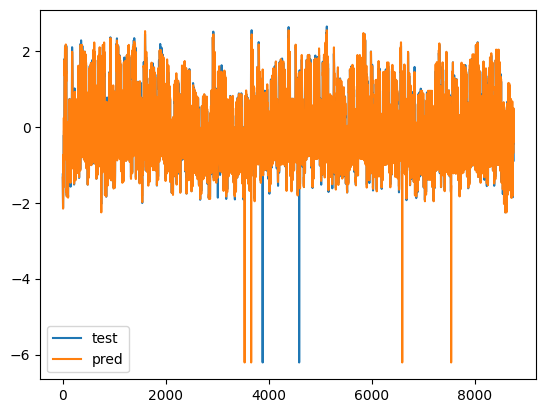

In [ ]:
plt.plot(Y_test.index, Y_test)
plt.plot(Y_test.index, y_pred_p)

plt.legend(["test","pred"])